## 1.2
First of all, we generate some random variable from multivariate normal distribution.

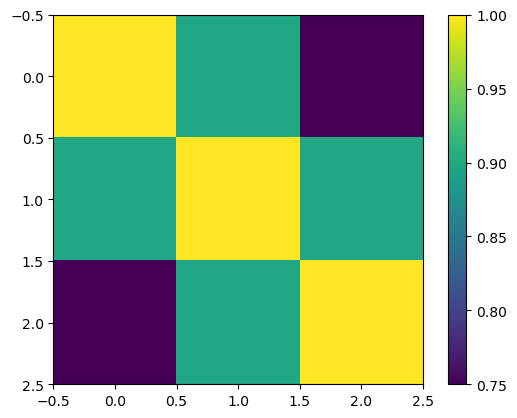

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();


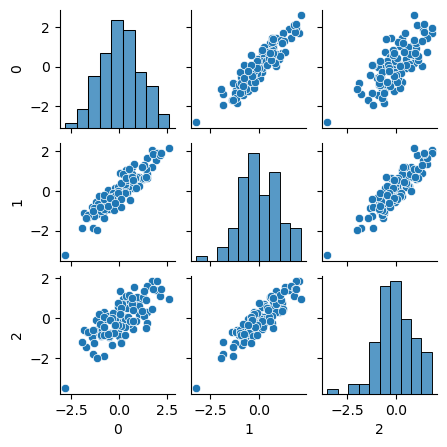

In [2]:
import seaborn
import pandas as pd
seaborn.pairplot(pd.DataFrame(x),height=1.5);

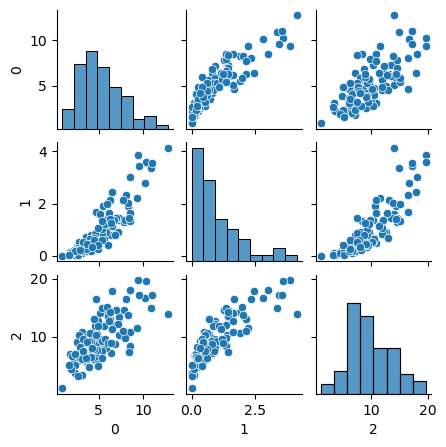

In [3]:
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))

seaborn.pairplot(pd.DataFrame(y),height=1.5);

With the random sample, we try to use a two pass approach.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p0, p1, p2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R_corr]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


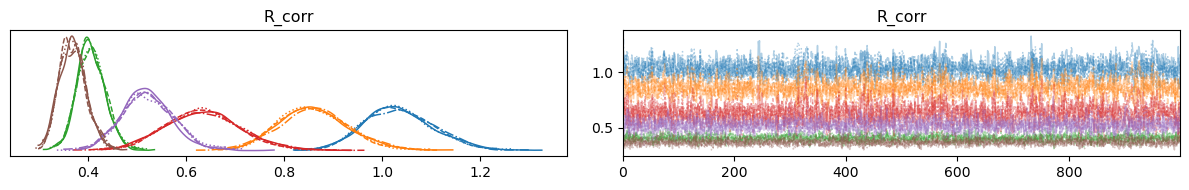

In [4]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

# 1) FIRST PASS: Fit Marginals
with pm.Model() as marginals_model:
    # Gamma for y0
    p0 = pm.HalfNormal("p0", sigma=10)
    y0_obs = pm.Gamma("y0_obs", alpha=p0, beta=1, observed=y[:, 0])
    
    # Exponential for y1
    p1 = pm.HalfNormal("p1", sigma=10)
    y1_obs = pm.Exponential("y1_obs", lam=p1, observed=y[:, 1])
    
    # ChiSquared for y2
    p2 = pm.HalfNormal("p2", sigma=10)
    y2_obs = pm.ChiSquared("y2_obs", nu=p2, observed=y[:, 2])

    trace_marg = pm.sample()  # Draw posterior samples for marginal parameters

# Extract posterior means (or medians) for the marginal parameters
p0_mean = trace_marg.posterior["p0"].mean().item()
p1_mean = trace_marg.posterior["p1"].mean().item()
p2_mean = trace_marg.posterior["p2"].mean().item()

# 2) SECOND PASS: Copula Structure on Latent Scale
# Transform the observed y's to Uniform(0,1) via each estimated marginal's CDF
U0 = stats.gamma.cdf(y[:,0], a=p0_mean, scale=1.0)      # alpha=p0_mean, beta=1 => scale=1
U1 = stats.expon.cdf(y[:,1], scale=1.0/p1_mean)        # lam = p1_mean => scale=1/p1_mean
U2 = stats.chi2.cdf(y[:,2], df=p2_mean)

U_data = np.column_stack([U0, U1, U2])

# Now convert Uniform(0,1) data to standard Normal quantiles
X_data = stats.norm.ppf(U_data)

with pm.Model() as copula_model:
    # Correlation prior
    L, R_corr, stds = pm.LKJCholeskyCov(
        "R_corr", n=3, eta=2.0,
        sd_dist=pm.Exponential.dist(1.0, shape=3),
        compute_corr=True
    )
    
    # We fit a multivariate Normal on the latent standardized data X_data
    pm.MvNormal("X_obs", mu=np.zeros(3), chol=L, observed=X_data)
    
    trace_copula = pm.sample()
    
az.plot_trace(trace_copula, var_names=["R_corr"])
plt.tight_layout()
plt.show()

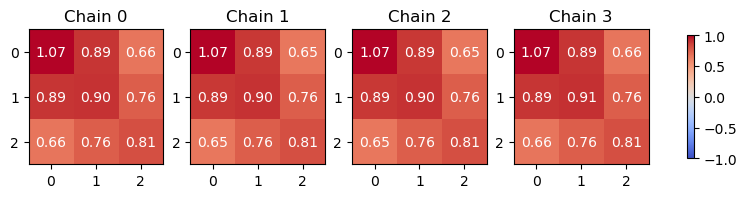

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose we have (chain, draw, 6) named post
post = trace_copula.posterior["R_corr"]   # shape => (4, 1000, 6)
chain_means = post.mean(dim="draw").values  # shape => (4, 6)

def cholesky_to_corr(L1d):
    """
    Given a length-6 array of Cholesky-factor entries for a 3x3 matrix,
    fill out the lower triangle and compute L @ L.T to get the correlation.
    We assume the typical order from PyMC's LKJCholeskyCov for a 3x3:
        [L[0,0], L[1,0], L[1,1], L[2,0], L[2,1], L[2,2]].
    """
    L = np.zeros((3, 3))
    L[0, 0] = L1d[0]
    L[1, 0] = L1d[1]
    L[1, 1] = L1d[2]
    L[2, 0] = L1d[3]
    L[2, 1] = L1d[4]
    L[2, 2] = L1d[5]
    
    # Correlation matrix is L * L^T
    return L @ L.T

# Convert each chain’s mean Cholesky factor to a 3x3 correlation matrix
corr_mats = [cholesky_to_corr(mean_1d) for mean_1d in chain_means]

# Now you can safely use imshow on each corr_mat
fig, axes = plt.subplots(1, len(corr_mats), figsize=(10, 2))
for i, c in enumerate(corr_mats):
    ax = axes[i] if len(corr_mats) > 1 else axes
    im = ax.imshow(c, vmin=-1, vmax=1, cmap="coolwarm")
    ax.set_title(f"Chain {i}")
    for row in range(3):
        for col in range(3):
            ax.text(col, row, f"{c[row,col]:.2f}", 
                    ha="center", va="center", color="w")

plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.show()

## 1.3
A copula is a function that couples (links) multivariate distribution functions to their one-dimensional marginal distributions. In simpler terms, it allows us to model the dependence structure among multiple variables separately from the individual marginal behaviors.

Formally, a copula for an $n$-dimensional random vector $(X_1, X_2, \dots, X_n)$ is the joint distribution of $(U_1, U_2, \dots, U_n)$, where $U_i = F_i(X_i)$ and $F_i$ is the marginal CDF of $X_i$. By modeling this copula function, we can capture how the variables move together (dependence) independent of their individual distributions.

In the first version (the single model approach), we simultaneously fit:
1. The marginal distributions,for each column of y.
2. A correlation structure on the latent (Normal) scale, tpically via an LKJ prior, by transforming each observation to the Normal scale via the inverse CDF (and using a Potential to incorporate the multivariate normal log-likelihood).

Both the marginals and the correlation (the copula) are estimated in one unified PyMC model.

In the two-pass approach, we:
1. Independently estimate and infer the parameters for each marginal distribution of y.
2. Transform y to Uniform(0,1) by applying each marginal's CDF. Then map these Uniform(0,1) values to standard Normal quantiles.
3. Estimate a correlation structure (LKJ prior again) on these transformed data in a second, separate step.

This approach clarifies how copula modeling can be performed by decoupling the marginal fitting from the dependency fitting. We first pin down how each variable behaves individually, and then focus on capturing their dependence structure (the copula) in a separate step.

## 1.4
### Using Copulas for Arbitrary Multivariate GLMs

**Goal**  
We often want to model multiple responses $Y_1, Y_2, \ldots, Y_k$ that can have different marginal distributions (Gamma, Poisson, Bernoulli, etc.) and yet exhibit correlation or dependence. A copula-based approach can help you build such a *multivariate* GLM by:

1. **Defining marginal regression models** for each $Y_i$. For instance,  
$$
   \mathbb{E}[Y_i] = g_i^{-1}(\mathbf{X}_i \beta_i), 
$$
   where $g_i^{-1}$ is the inverse link function relevant to $Y_i$'s distribution (log link for Gamma, logit for Bernoulli, etc.).

2. **After inferring marginal parameters** (e.g., regression coefficients, shape/rate parameters) from each GLM, you map each $Y_i$ to a *latent* variable, typically by applying the fitted CDF of the respective distribution.

3. **You then model the joint dependence** among the latent variables $(U_1, U_2, \ldots, U_k)$ through a copula, typically using:
$$
   (Z_1, Z_2, \dots, Z_k) = \left( \Phi^{-1}(U_1), \Phi^{-1}(U_2), \dots, \Phi^{-1}(U_k) \right),
$$
   and imposing a parametric correlation structure on $(Z_1, Z_2, \dots, Z_k)$.

## 2

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# 1. Simulate data
np.random.seed(42)
n = 100  # number of observations
p = 10   # number of predictors
X = np.random.normal(size=(n, p))

# True coefficients (only some are nonzero)
true_beta = np.array([3, 0, 0, -2, 0, 1.5, 0, 0, 0, 0])
y = X @ true_beta + np.random.normal(scale=1.0, size=n)

# 2. Spike and Slab Model
with pm.Model() as spike_slab_model:
    # Prior inclusion probabilities
    p_incl = pm.Beta('p_incl', alpha=1, beta=1)
    
    # Inclusion indicator
    gamma = pm.Bernoulli('gamma', p=p_incl, shape=p)
    
    # Slab (wide) prior
    slab = pm.Normal('slab', mu=0, sigma=10, shape=p)
    
    # Actual beta is spike * slab
    beta = pm.Deterministic('beta', gamma * slab)
    
    # Likelihood
    mu = pm.math.dot(X, beta)
    sigma = pm.HalfNormal('sigma', 1.0)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    spike_slab_trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

# 3. Diffuse Normal Prior (no variable selection)
with pm.Model() as diffuse_model:
    beta = pm.Normal('beta', mu=0, sigma=10, shape=p)
    mu = pm.math.dot(X, beta)
    sigma = pm.HalfNormal('sigma', 1.0)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    diffuse_trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_incl, slab, sigma]
>BinaryGibbsMetropolis: [gamma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 268 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


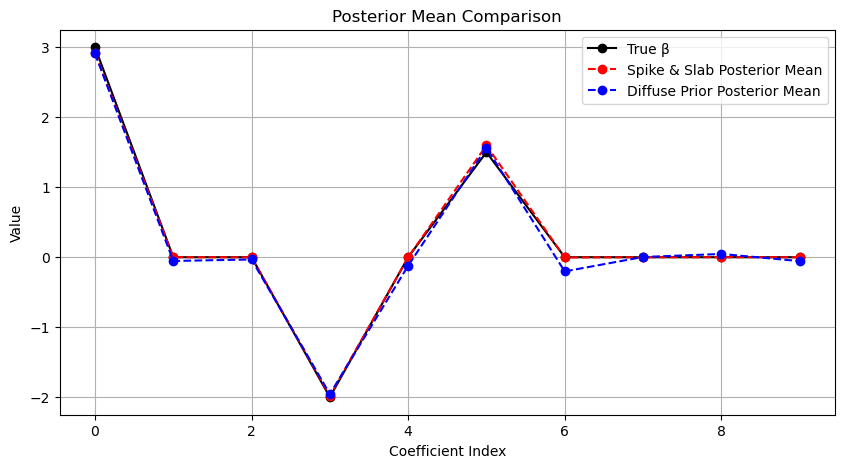

In [2]:
# Compare posterior means of beta
mean_spike_slab = spike_slab_trace.posterior['beta'].mean(dim=["chain", "draw"]).values
mean_diffuse = diffuse_trace.posterior['beta'].mean(dim=["chain", "draw"]).values

plt.figure(figsize=(10, 5))
plt.plot(true_beta, 'ko-', label='True β')
plt.plot(mean_spike_slab, 'ro--', label='Spike & Slab Posterior Mean')
plt.plot(mean_diffuse, 'bo--', label='Diffuse Prior Posterior Mean')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value')
plt.title('Posterior Mean Comparison')
plt.grid(True)
plt.show()

## 3

In [3]:
import numpy as np
import pymc as pm
import arviz as az

np.random.seed(42)

# Number of samples (rows) and predictors (columns)
N = 200
p = 20

# "True" coefficients for only 3 relevant predictors
beta_true = np.zeros(p)
beta_true[[0, 5, 10]] = [2.0, -3.0, 1.5]  # non-zero only at indices 0,5,10

# Create design matrix X
X = np.random.normal(size=(N,p))

# Noise standard deviation
sigma_true = 1.0

# Generate response
y = X @ beta_true + np.random.normal(loc=0, scale=sigma_true, size=N)

In [4]:
with pm.Model() as horseshoe_model:
    # Global shrinkage parameter
    tau = pm.HalfCauchy('tau', beta=1.0)
    
    # Local shrinkage parameters for each coefficient
    lam = pm.HalfCauchy('lambda', beta=1.0, shape=p)
    
    # Regression coefficients
    beta = pm.Normal('beta', mu=0, sigma=tau * lam, shape=p)
    
    # Noise std
    sigma = pm.HalfCauchy('sigma', beta=2.0)
    
    # Likelihood
    mu = pm.math.dot(X, beta)
    obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    # Sample
    horseshoe_trace = pm.sample(draws=2000, tune=1000, target_accept=0.9, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lambda, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 68 seconds.
There were 939 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],1.998,0.076,1.855,2.141,0.001,0.001,6165.0,4409.0,1.00
beta[1],-0.001,0.037,-0.077,0.072,0.001,0.001,2658.0,3224.0,1.00
beta[2],0.009,0.039,-0.061,0.097,0.001,0.001,2312.0,2292.0,1.00
beta[3],-0.017,0.044,-0.108,0.065,0.001,0.001,2786.0,2372.0,1.00
beta[4],0.076,0.072,-0.025,0.213,0.002,0.001,2427.0,4736.0,1.00
beta[5],-2.977,0.073,-3.111,-2.839,0.002,0.002,1319.0,699.0,1.00
beta[6],0.005,0.039,-0.072,0.089,0.001,0.001,2969.0,2674.0,1.00
beta[7],0.003,0.040,-0.079,0.086,0.001,0.002,1515.0,522.0,1.01
beta[8],-0.014,0.045,-0.125,0.058,0.001,0.001,3202.0,1779.0,1.00
beta[9],0.005,0.037,-0.075,0.076,0.001,0.001,3563.0,2054.0,1.00


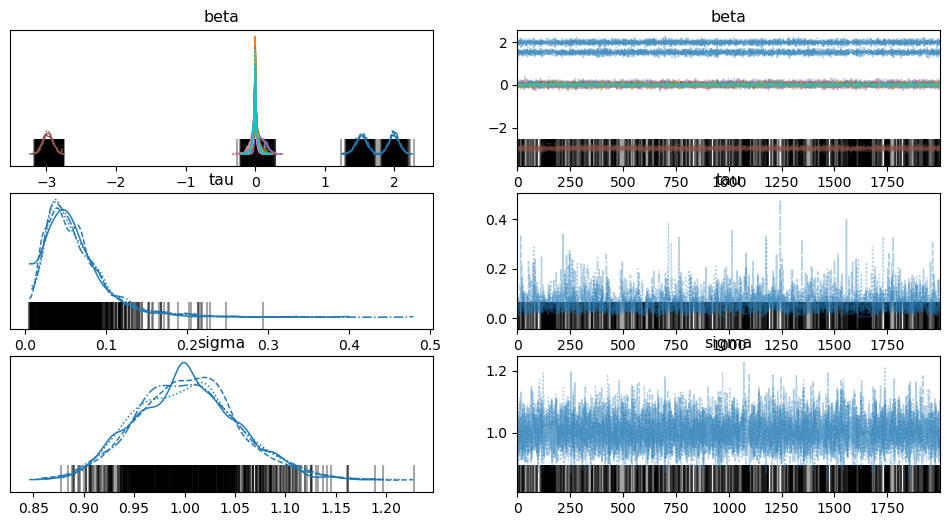

In [5]:
az.plot_trace(horseshoe_trace, var_names=['beta', 'tau', 'sigma'], compact=True);
az.summary(horseshoe_trace, var_names=['beta', 'tau', 'sigma'])

In [6]:
with pm.Model() as spike_slab_model:
    # Prior on inclusion probability (how many coefficients we expect to be nonzero)
    pi = pm.Beta('pi', alpha=1, beta=1)
    
    # Inclusion indicators for each coefficient: 0 or 1
    gamma = pm.Bernoulli('gamma', p=pi, shape=p)
    
    # Slab part: wide normal for "active" coefficients
    slab_std = pm.Exponential('slab_std', 1.0)
    
    # Latent normal for each coeff, forced to zero if gamma=0
    beta_nonzero = pm.Normal('beta_nonzero', mu=0, sigma=slab_std, shape=p)
    
    # Actual coefficient is gamma * latent
    beta = pm.Deterministic('beta', gamma * beta_nonzero)
    
    # Noise
    sigma = pm.HalfCauchy('sigma', beta=2.0)
    
    # Likelihood
    mu = pm.math.dot(X, beta)
    obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    spike_slab_trace = pm.sample(
        draws=3000,
        tune=2000,
        target_accept=0.9,
        chains=2,
        random_seed=123
    )

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [pi, slab_std, beta_nonzero, sigma]
>BinaryGibbsMetropolis: [gamma]


Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 40 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-pac

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],2.000,0.074,1.864,2.143,0.001,0.001,3530.0,2400.0,1.0
beta[1],0.000,0.007,0.000,-0.000,0.000,0.001,3933.0,4589.0,1.0
beta[2],0.000,0.008,0.000,0.000,0.000,0.001,4220.0,3918.0,1.0
beta[3],-0.001,0.011,-0.000,0.000,0.000,0.001,3619.0,5096.0,1.0
beta[4],0.012,0.047,0.000,0.107,0.001,0.002,1595.0,1404.0,1.0
beta[5],-2.982,0.071,-3.116,-2.851,0.001,0.001,3473.0,2612.0,1.0
beta[6],0.000,0.006,-0.000,0.000,0.000,0.001,3772.0,3132.0,1.0
beta[7],-0.000,0.009,-0.000,-0.000,0.000,0.001,4746.0,5072.0,1.0
beta[8],-0.001,0.011,0.000,-0.000,0.000,0.001,4188.0,4756.0,1.0
beta[9],0.000,0.006,-0.000,0.000,0.000,0.001,6335.0,4731.0,1.0


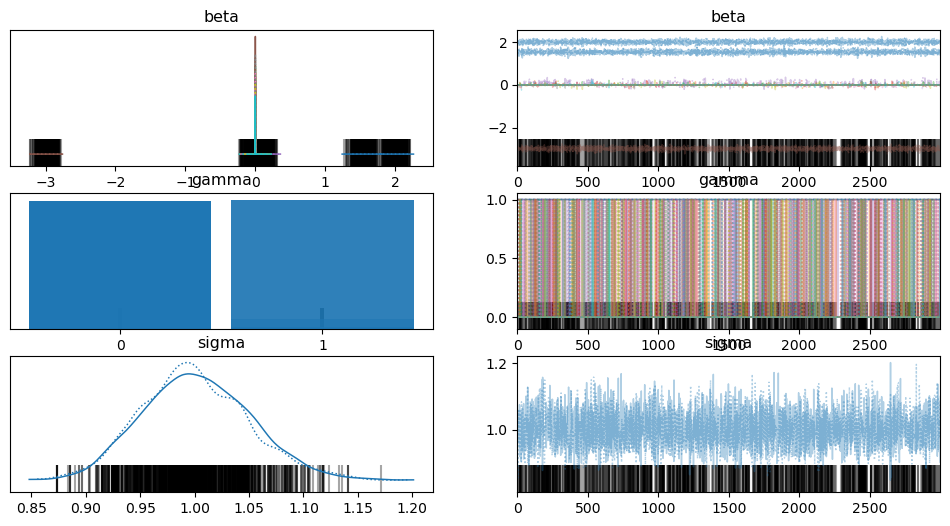

In [7]:
az.plot_trace(spike_slab_trace, var_names=['beta', 'gamma', 'sigma'], compact=True);
az.summary(spike_slab_trace, var_names=['beta', 'gamma', 'sigma'])

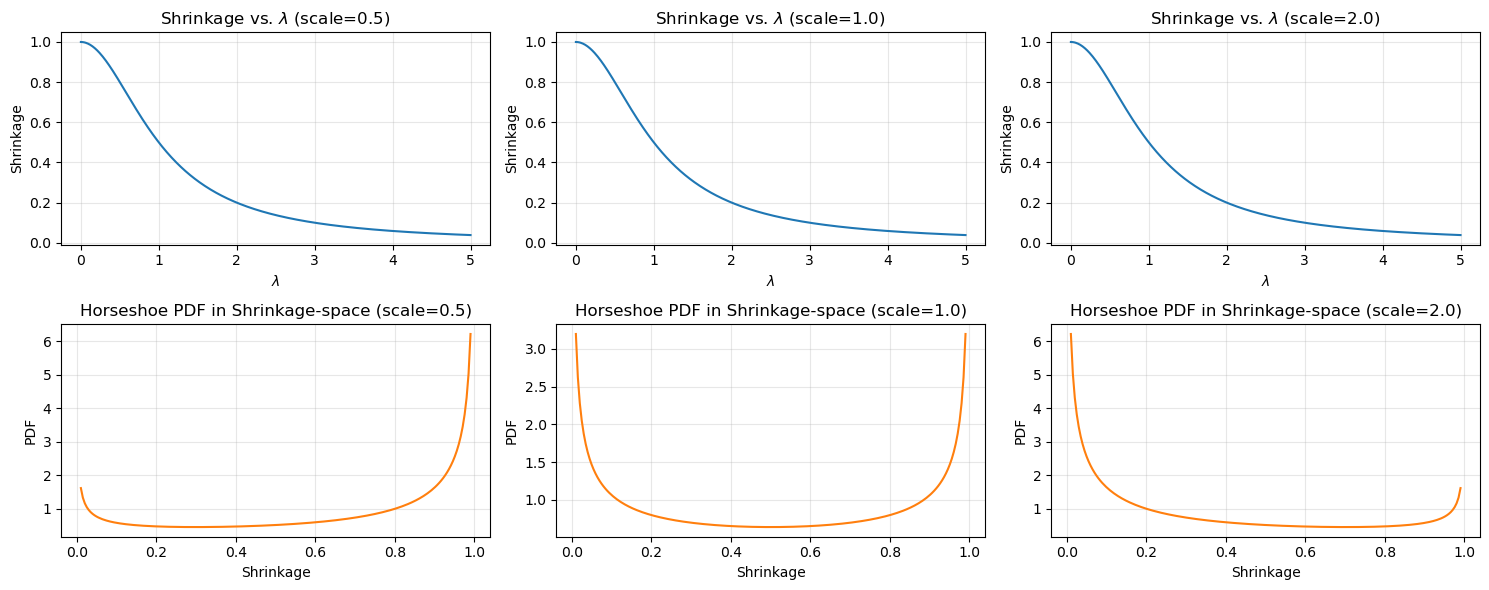

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Create a figure with 2 rows, 3 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 6))

# We'll vary the 'scale' parameter of the Half-Cauchy
scales = [0.5, 1.0, 2.0]

# Lambda support for top-row plots
lambda_support = np.linspace(0, 5, 500)

# Shrinkage support for bottom-row plots
shrinkage_support = np.linspace(0.01, 0.99, 200)

for col, scale in enumerate(scales):
    # ========== Top row: Shrinkage vs. lambda ==========
    # Shrinkage = 1 / (1 + lambda^2)
    shrinkage = 1 / (1 + lambda_support**2)
    
    axs[0, col].plot(lambda_support, shrinkage, color='C0')
    axs[0, col].set_xlabel(r'$\lambda$')
    axs[0, col].set_ylabel('Shrinkage')
    axs[0, col].set_title(f'Shrinkage vs. $\\lambda$ (scale={scale})')
    axs[0, col].grid(True, alpha=0.3)
    
    # ========== Bottom row: PDF over shrinkage ==========
    # We need the PDF under the transformation from lambda -> shrinkage
    # If shrinkage = 1/(1 + lambda^2), then lambda = sqrt((1/shrinkage) - 1)
    #   d(lambda)/d(shrinkage) = -1/(2*sqrt((1/shrinkage)-1)) * (1/shrinkage^2)
    # So the absolute Jacobian factor is:
    #   0.5 * (1/shrinkage - 1)^(-0.5) * shrinkage^(-2)
    
    lambda_from_s = np.sqrt((1 / shrinkage_support) - 1)  # invert
    jacobian = 0.5 * (1 / shrinkage_support - 1)**(-0.5) * shrinkage_support**(-2)
    
    # The underlying lambda ~ HalfCauchy(scale=scale)
    # => pdf_lambda = stats.halfcauchy(scale=scale).pdf(lambda_from_s)
    pdf_shrinkage = stats.halfcauchy(scale=scale).pdf(lambda_from_s) * jacobian
    
    axs[1, col].plot(shrinkage_support, pdf_shrinkage, color='C1')
    axs[1, col].set_xlabel('Shrinkage')
    axs[1, col].set_ylabel('PDF')
    axs[1, col].set_title(f'Horseshoe PDF in Shrinkage-space (scale={scale})')
    axs[1, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()